In [63]:
%load_ext autoreload
%autoreload 2
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from source.read_open_dataset import DatasetOpenDataset, openDatasetParticipants
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL

FEATURE_SIZE = 16
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
CLASS_LABELS = ['Sedentary', 'Light']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading the dataset

In [64]:
dataset = DatasetOpenDataset(mode='leave-one-subject')
dataset.loadData()

True

In [65]:
print('Unique Labels (intensities): {}'.format(np.unique(dataset.Int_train)))
print('Signals: {}'.format(dataset.signals))
print('Sedentary windows: {}  Light windows: {}'.format(len(dataset.Int_train[dataset.Int_train == 0]), len(dataset.Int_train[dataset.Int_train == 1])))

Unique Labels (intensities): [0. 1.]
Signals: ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'heart_rate', 'skin_temperature', 'galvanic_skin_response', 'rr_interval', 'light', 'barometer', 'altimeter']
Sedentary windows: 24866  Light windows: 1036


# Data preparation

In [91]:
# Preparing data
ts_train = TSerie(dataset.X_train[:,:,:6], dataset.Int_train)
ts_test = TSerie(dataset.X_test[:,:,:6], dataset.Int_test)

ts_train.center()
ts_test.center()

ts_train.folding_features_v2()
ts_test.folding_features_v2()

# Engenharia de features

In [92]:

# Getting features
model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
ts_test.features = model.transform(ts_test.features)

In [93]:

# Getting features
model_vis = UMAP_FL(n_components=2,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
train_proj = model_vis.fit_transform(ts_train.features)
test_proj = model_vis.transform(ts_test.features)

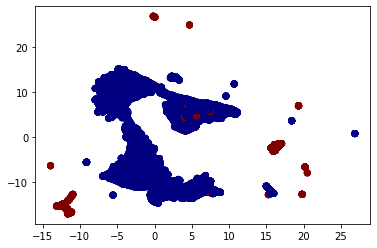

In [94]:
import matplotlib.pyplot as plt

plt.scatter(train_proj[:,0], train_proj[:,1], c = ts_train.y, cmap='jet')


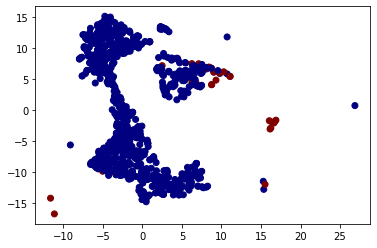

In [95]:
plt.scatter(test_proj[:,0], test_proj[:,1], c = ts_test.y, cmap='jet')

## Risk Minimization - SVM

In [107]:
from sklearn.svm import SVC

# clf = SVC(gamma='auto', C=1)
clf = SVC(kernel="linear", C=1)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))

              precision    recall  f1-score   support

   Sedentary       0.97      1.00      0.98       888
       Light       1.00      0.24      0.39        37

    accuracy                           0.97       925
   macro avg       0.98      0.62      0.69       925
weighted avg       0.97      0.97      0.96       925

0.6216216216216216


: 

## Risk Minimization -  Neural Network model

In [97]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=400)
clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))
print(metrics.balanced_accuracy_score(ts_test.y, test_pr))

              precision    recall  f1-score   support

   Sedentary       0.97      1.00      0.98       888
       Light       1.00      0.24      0.39        37

    accuracy                           0.97       925
   macro avg       0.98      0.62      0.69       925
weighted avg       0.97      0.97      0.96       925

0.6216216216216216


# Straight-forward Classifier


In [104]:

from sklearn.tree import DecisionTreeClassifier

# clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
# clf = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(ts_train.features, ts_train.y)


train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

In [105]:
print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))
print(metrics.balanced_accuracy_score(ts_test.y, test_pr))

              precision    recall  f1-score   support

   Sedentary       0.97      0.99      0.98       888
       Light       0.43      0.24      0.31        37

    accuracy                           0.96       925
   macro avg       0.70      0.61      0.64       925
weighted avg       0.95      0.96      0.95       925

0.6148648648648649


# Bayesian Risk
